### Bayesian Neural Networks from Dropout

Based on <a href="https://arxiv.org/abs/1506.02142">this</a> paper.

In [3]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt

In [212]:
[1,2,3][0:2]

[1, 2]

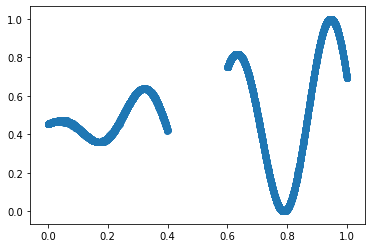

In [222]:
# Synthesise some data
n = 10000

X = np.linspace(0,200, n)/10
y = X*np.cos(X) + np.sin(X) * np.random.normal(0,0.1, n)

y = (y - np.min(y))/(np.max(y) - np.min(y))
X = (X - np.min(X))/(np.max(X) - np.min(X))

X = list(X)
y = list(y)

X_missing = X[:4000] + X[6000:]
y_missing = y[:4000] + y[6000:]

plt.scatter(X_missing, y_missing)

In [217]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return K.layers.Dropout(p)(input_tensor, training=True)
    else:
        return K.layers.Dropout(p)(input_tensor)

In [227]:
drop_rate = 0.9
mc = True
units = 1028

inputs = K.layers.Input(shape=(1,))

output_1 = K.layers.Dense(units, activation='relu')(inputs)
drop_1 = get_dropout(output_1, p=drop_rate, mc=mc)

output_2 = K.layers.Dense(units//2, activation='relu')(drop_1)
drop_2 = get_dropout(output_2, p=drop_rate, mc=mc)

predictions = K.layers.Dense(1)(drop_2)

In [228]:
sgd = K.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model = K.Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mse',
             batch_size = 128)
model.fit(X_missing, y_missing, epochs = 500)  # starts training

Train on 8000 samples
Epoch 1/500
8000/8000 [==============================] - 2s 216us/sample - loss: 0.1001
Epoch 2/500
8000/8000 [==============================] - 1s 157us/sample - loss: 0.0708
Epoch 3/500
8000/8000 [==============================] - 1s 155us/sample - loss: 0.0661
Epoch 4/500
8000/8000 [==============================] - 1s 149us/sample - loss: 0.0642
Epoch 5/500
8000/8000 [==============================] - 1s 146us/sample - loss: 0.0626
Epoch 6/500
8000/8000 [==============================] - 1s 151us/sample - loss: 0.0613
Epoch 7/500
8000/8000 [==============================] - 1s 148us/sample - loss: 0.0600
Epoch 8/500
8000/8000 [==============================] - 1s 147us/sample - loss: 0.0573
Epoch 9/500
8000/8000 [==============================] - 1s 146us/sample - loss: 0.0547
Epoch 10/500
8000/8000 [==============================] - 1s 144us/sample - loss: 0.0534
Epoch 11/500
8000/8000 [==============================] - 1s 150us/sample - loss: 0.0536
Epoch 12

KeyboardInterrupt: 

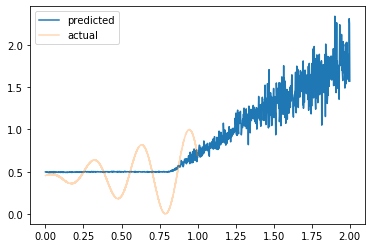

In [232]:
mc_preds = []
mc_samples = 50

X_test = np.linspace(0,2, 1000)

for i in range(mc_samples):
    
    mc_preds.append(model.predict(X_test))
    
mc_preds = np.array(mc_preds)

preds = np.mean(mc_preds, axis=0)

plt.plot(X_test, preds, label = "predicted")
plt.plot(X, y, alpha = 0.3, label = "actual")
plt.legend()

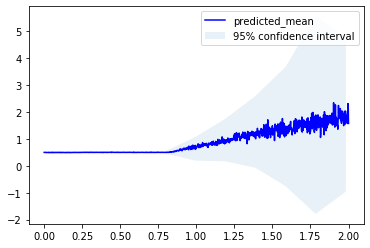

In [259]:
plt.plot(X_test, preds, label = "predicted_mean", c='b')

std = np.std(mc_preds, axis=0)

upper = preds + 1.97 * std
lower = preds - 1.97 * std

upper = np.reshape(upper, (-1))
lower = np.reshape(lower, (-1))

plt.fill_between(X_test[::99], lower[::99], upper[::99], interpolate = True, 
                 alpha = 0.1, label = "95% confidence interval")
plt.legend()

### Observations

 * Where data exists, the confidence intervals aren't very good since dropout doesn't seem to produce neural nets with very different predictions - even though there is a lot of noise.

 * The main benefit seems to be in quantifying uncertainty on predictions made with data that is outside the range of the training data.
 
 * Quantifying the uncertainty when making predictions within "holes" in the original data, ie areas which are surrounded by data, but themselves contain no data, is also hard for MC dropout. The neural nets tend to just connect adjacent points with a line, no matter how far apart those points are.